In [1]:
%matplotlib inline
import brian2 as b2
from brian2 import *

In [2]:
# INFO FROM PAPER
# coupled all to all
# NO refractory period

# QUESTIONS:
# initial conditions? Imean?

def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')
    show()


In [3]:

# Parameters
N     =     3                             # number of neurons
gl    =     0.1   * 10e-6                 # conductance of the voltage-independent leak current
Vl    =     -60   *       mV              # reversal potential of the voltage-independent leak current
# C     =       1   *       ufarad        # membrane capacitance
tau   =     10    *       ms              # passive membrane time constant
theta =     -40   *       mV              # membrane potential threshold
tau1  =       3   *       ms              
tau2  =       1   *       ms    
I0    =    2.3    *     uvolt 
ISyn_bar = 0.78   *       uvolt


# FOR INITIAL CONDITION 
# T = -tau * log((tau/second * I0 - theta) / (tau/second * I0 - Vl)) # FROM PREPRINT PAPER
T = -tau * log(1 - gl/I0 * (theta - Vl)) # FROM FINAL PAPER

c = 1


In [4]:
k = tau/tau2

eqs = '''
dV/dt = (-(V-Vl)+I_syn + I0)/tau : volt
'''

integ = 1*second
k = integ/tau2

syn_eqs = '''
dI_syn/dt = (k*s - I_syn)/tau1 : volt 
ds/dt = -s/tau2 : volt
'''
eqs = Equations(eqs + syn_eqs)


/home/fabio/.cython/brian_extensions/_cython_magic_bfb1b4505a6c6e0230829b8cc067755c.cpp:30:10: fatal error: Python.h: No such file or directory
   30 | #include "Python.h"
      |          ^~~~~~~~~~
compilation terminated.
WARNING    Cannot use Cython, a test compilation failed: command 'x86_64-linux-gnu-gcc' failed with exit status 1 (CompileError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


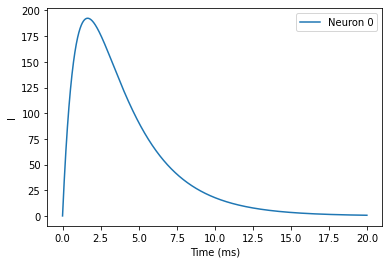

In [5]:
start_scope()
defaultclock.dt = 0.01*ms

########### NEURONS #######################
G = NeuronGroup(N, eqs, threshold='V > theta', reset='V = Vl', method='exact')


########### SYNAPSES #######################    
S = Synapses(G, G)

## Connect
S.connect(condition='i!=j')
S.s = 1 * mV

## INIT.
for idx in range(N):
    # curr_V0 = tau/second * I0 + (Vl - (tau/second) * I0) * exp((-c * idx * T) / (N * tau)) # FROM PREPRINT PAPER
    curr_V0 = Vl + I0/gl * (1 - exp(-c * (idx * T)/(N * tau))) # FROM FINAL PAPER
    G.V[idx] = curr_V0
    S.I_syn[idx] = 0



########## VISUALISE ####################### 
par = 'I'
runtime = 20*ms

# State Monitors
MV = StateMonitor(G, 'V', record=True)
MC = StateMonitor(S, 'I_syn', record=True)

# Run.
run(runtime)

# Plotting
for idx in range (1):
    off = idx * 50
    if par == 'V':
        plot(MV.t/ms, MV.V[off]/mV, label=('Neuron ' + str(off)))
    if par == 'I':
        plot(MC.t/ms, MC.I_syn[off]/mV, label=('Neuron ' + str(off)))

xlabel('Time (ms)')
ylabel(par)
legend();

# Experimental Part

In [6]:
def nice_plot(sp_m, st_m, neuron_idxs, plot_voltages=True):

    fig, ax = plt.subplots(4, figsize=(10, 5), sharex=True)

    ax[0].plot(sp_m.t / ms, sp_m.i, '.k', ms=3)

    if plot_voltages:
        for i in neuron_idxs:
            ax[1].plot(st_m.t / ms, st_m.V[i] / mV, label="Neuron " + str(i))

    ax[0].set_ylabel("cells")
    
    ax[1].legend(loc="upper right")
    ax[1].set_ylabel("Voltages")
    
    ax[2].plot(st_m.t / ms, st_m.s[1] / mV, lw=1, color="b", ls="--")
    ax[2].set_ylabel("s")

    ax[3].plot(st_m.t / ms, st_m.I_syn[1] / mV, lw=1, color="b", ls="--")
    ax[3].set_ylabel("I_syn")
    ax[3].set_xlabel("time (ms)")
    
    plt.show()

In [7]:

# Parameters
N        =     128                           # number of neurons
gl       =     0.1   *    mS / cm**2         # conductance of the voltage-independent leak current
Vl       =     -60   *       mV              # reversal potential of the voltage-independent leak current
C        =       1   *  ufarad / cm**2       # membrane capacitance
tau      =     10    *       ms              # passive membrane time constant
theta    =     -40   *       mV              # membrane potential threshold
tau1     =       3   *       ms              
tau2     =       1   *       ms    
I0       =    2.3    *     uA / cm**2        # I0 / C -> get 2.3 kHz, time that by tau to get 23 mvolts. 
I_syn_bar =    0.3   *     uA / cm**2


# FOR INITIAL CONDITION 
# T = -tau * log((tau/second * I0 - theta) / (tau/second * I0 - Vl)) # FROM PREPRINT PAPER
T = -tau * log(1 - gl/I0 * (theta - Vl)) # FROM FINAL PAPER

c = 1

In [8]:
integ = 1
k = integ/tau2 #  1/time

# Try to add 1/C and change I0 accordingly.
eqs_with_Ibar = '''
dV/dt = (-gl * (V - Vl) + I_syn + I0) / C : volt
I_syn = (I_syn_bar / N) * f * tau : amp / metre**2
df/dt = (k * s - f) / tau1 : 1 / second
ds/dt = -s / tau2 : 1
'''

# f is 1/time
# s is dimensionless.
# k should have dims so that dimensions match. (1/time). And integ 1 (dimensionless)
eqs = '''
dV/dt = (-(V-Vl)+ I_tot + I0)/tau : volt
I_tot = I_syn : volt
dI_syn/dt = (k*s - I_syn)/tau1 : volt
ds/dt = -s/tau2 : volt
'''


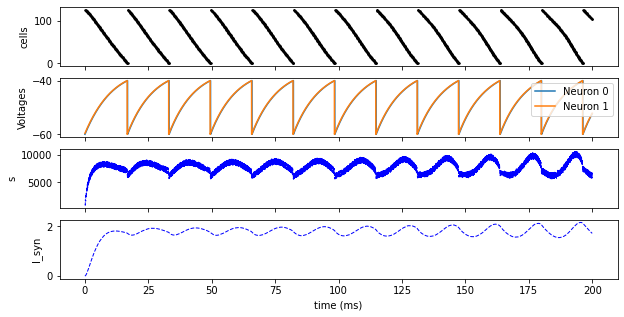

In [9]:
'''
    set the value of s so that f(t) integrated is 1. 
'''

start_scope()
defaultclock.dt = 0.01 * ms
runtime = 200 * ms

########### NEURONS #######################
G = NeuronGroup(N, eqs_with_Ibar, threshold='V > theta', reset='V = Vl', method='exact')
#G = NeuronGroup(N, eqs, threshold='V > theta', reset='V = Vl', method='exact')

G.V = -60 * mV
G.s = 1

########### SYNAPSES #######################    
S = Synapses(G, G, on_pre= "s += 1")

## Connect
S.connect(condition='i!=j')

# INIT.
for idx in range(N):
    #curr_V0 = tau/second * I0 + (Vl - (tau/second) * I0) * exp((-c * idx * T) / (N * tau)) # FROM PREPRINT PAPER
    curr_V0 = Vl + I0/gl * (1 - exp(-c * (idx * T)/(N * tau))) # FROM FINAL PAPER
    G.V[idx] = curr_V0


# MONITORS
sp_m = b2.SpikeMonitor(G)

st_m = b2.StateMonitor(G,["V", "I_syn", "s"],record=True)

net = b2.Network(G)
net.add(sp_m)
net.add(S)
net.add(st_m)

b2.run(runtime)

neuron_idxs = [0, 1]
nice_plot(sp_m, st_m, neuron_idxs)